Loaded existing checkpoint.
Epoch 0: Loss = 0.004402
Epoch 100: Loss = 0.004249
Epoch 200: Loss = 0.005332
Epoch 300: Loss = 0.005103
Epoch 400: Loss = 0.004065
Epoch 500: Loss = 0.003937
Epoch 600: Loss = 0.004021
Epoch 700: Loss = 0.004004
Epoch 800: Loss = 0.003673
Epoch 900: Loss = 0.004215


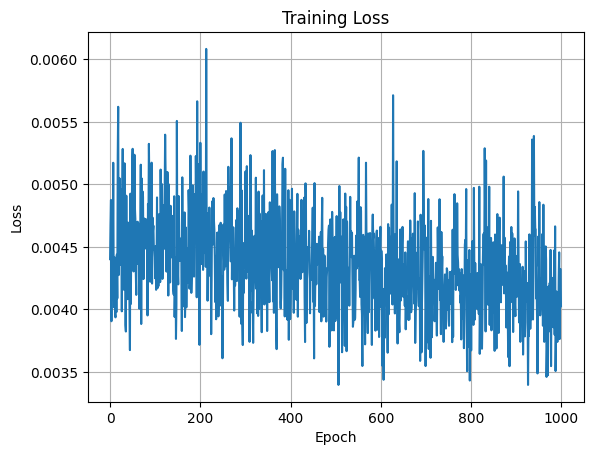

In [43]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# Settings
T = 1.0
N = 40
dt = T / N
sigma = 1.0
batch_size = 512
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== Neural Networks ==========
class ZNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

class QNet(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

# ========== Deep BSDE ==========
class DeepBSDE_LQ(nn.Module):
    def __init__(self):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32))
        self.z_net = ZNet().to(device)
        self.q_net = QNet().to(device)

    def forward(self):
        x = torch.ones(batch_size, 1, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        Y = self.Y0.repeat(batch_size, 1)

        total_residual_loss = 0.0

        for _ in range(N):
            z = self.z_net(t, x)
            q = self.q_net(t, x)

            dW = torch.randn(batch_size, 1, device=device) * np.sqrt(dt)

            x_next = x + q * dt + sigma * dW
            f = 0.5 * q**2

            Y_next = Y - f * dt + z * dW

            # --- Residual loss: Enforce BSDE dynamics ---
            residual = Y_next.detach() - Y + f * dt - z * dW
            total_residual_loss += torch.mean(residual**2)

            # Update variables
            Y = Y_next
            x = x_next
            t += dt

        # Terminal loss
        terminal = 0.5 * x**2
        terminal_loss = torch.mean((Y - terminal)**2)

        # Total loss = residual + terminal
        return terminal_loss + total_residual_loss

# ========== Train ==========
model = DeepBSDE_LQ().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

if os.path.exists("checkpoint_bsde.pth"):
    checkpoint = torch.load("checkpoint_bsde.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Loaded existing checkpoint.")
else:
    print("No checkpoint found, training from scratch.")

losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    loss = model()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, "checkpoint_bsde.pth")

plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


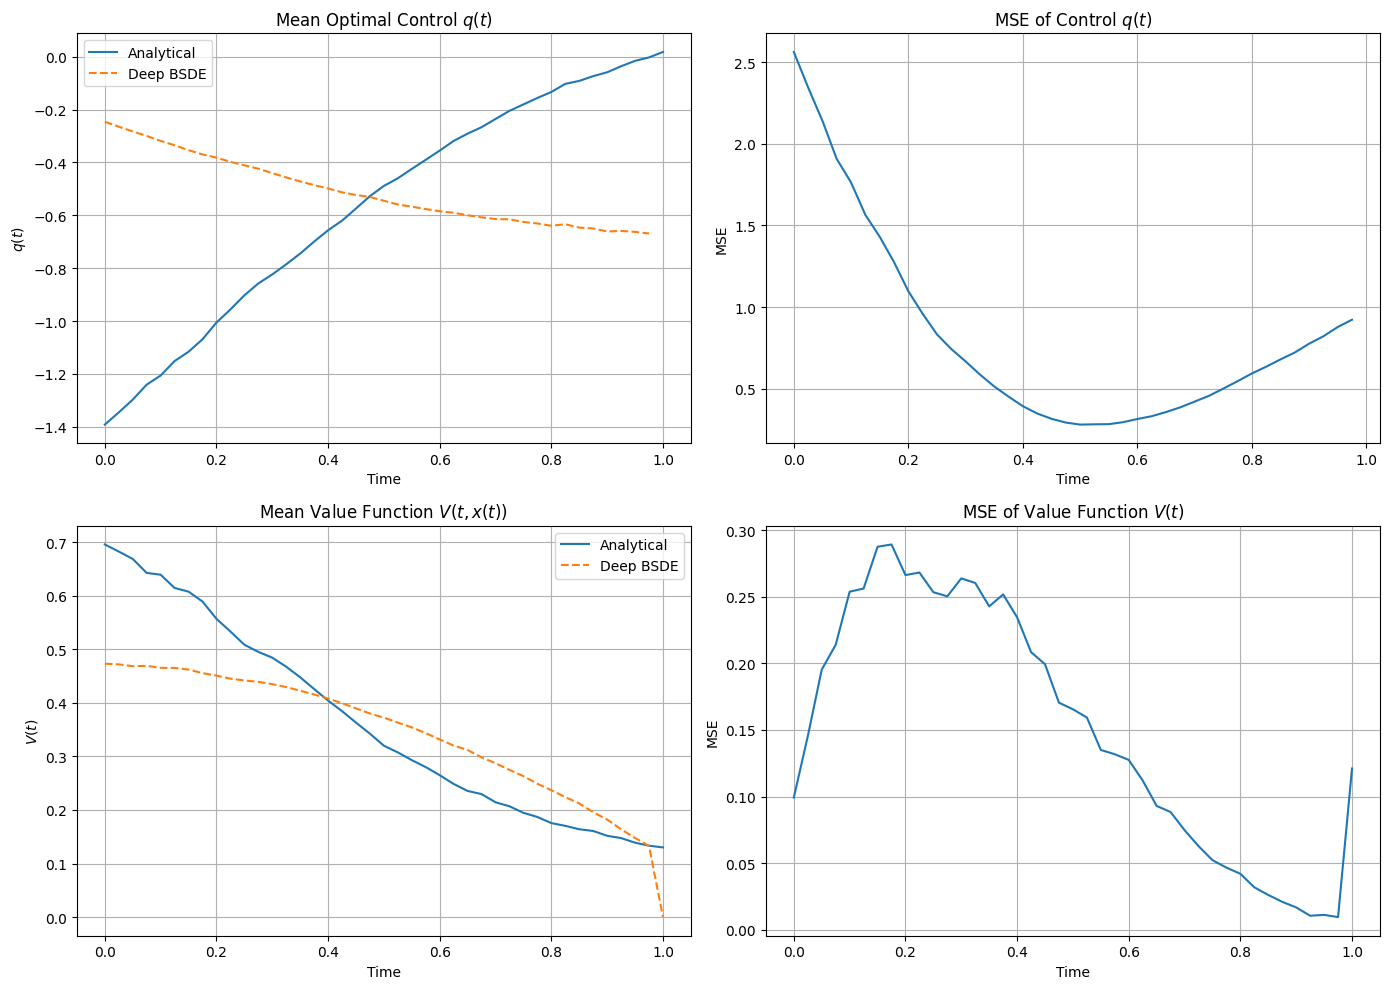

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for simulation
n_paths = 1000
t_vals = np.linspace(0, T, N + 1)
dt = T / N

# Containers for comparison
x_all = np.zeros((N + 1, n_paths))
q_nn_all = np.zeros((N + 1, n_paths))
q_true_all = np.zeros((N + 1, n_paths))
V_nn_all = np.zeros((N + 1, n_paths))
V_true_all = np.zeros((N + 1, n_paths))

# Deep BSDE components
model.eval()
with torch.no_grad():
    for i in range(n_paths // batch_size):
        x = torch.ones(batch_size, 1, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        Y = model.Y0.repeat(batch_size, 1)

        for j in range(N + 1):
            idx = i * batch_size

            # Save state and predictions
            x_cpu = x.cpu().numpy().squeeze()
            x_all[j, idx:idx+batch_size] = x_cpu
            q_true_all[j, idx:idx+batch_size] = -np.exp(T - t_vals[j]) * x_cpu
            V_true_all[j, idx:idx+batch_size] = 0.5 * np.exp(T - t_vals[j]) * x_cpu**2

            if j < N:
                q = model.q_net(t, x).cpu().numpy().squeeze()
                q_nn_all[j, idx:idx+batch_size] = q
                f = 0.5 * q**2

                z = model.z_net(t, x)
                dW = torch.randn(batch_size, 1, device=device) * np.sqrt(dt)
                x = x + torch.tensor(q).view(-1, 1).to(device) * dt + sigma * dW

                Y = Y - torch.tensor(f).view(-1, 1).to(device) * dt + z * dW
                t += dt
                V_nn_all[j, idx:idx+batch_size] = Y.cpu().numpy().squeeze()

# Plot results
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Plot control comparison
axs[0, 0].plot(t_vals, q_true_all.mean(axis=1), label="Analytical")
axs[0, 0].plot(t_vals[:-1], q_nn_all[:-1].mean(axis=1), label="Deep BSDE", linestyle="--")
axs[0, 0].set_title("Mean Optimal Control $q(t)$")
axs[0, 0].set_xlabel("Time")
axs[0, 0].set_ylabel("$q(t)$")
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot control error
control_error = np.mean((q_nn_all[:-1] - q_true_all[:-1])**2, axis=1)
axs[0, 1].plot(t_vals[:-1], control_error)
axs[0, 1].set_title("MSE of Control $q(t)$")
axs[0, 1].set_xlabel("Time")
axs[0, 1].set_ylabel("MSE")
axs[0, 1].grid(True)

# Plot value comparison
axs[1, 0].plot(t_vals, V_true_all.mean(axis=1), label="Analytical")
axs[1, 0].plot(t_vals, V_nn_all.mean(axis=1), label="Deep BSDE", linestyle="--")
axs[1, 0].set_title("Mean Value Function $V(t, x(t))$")
axs[1, 0].set_xlabel("Time")
axs[1, 0].set_ylabel("$V(t)$")
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot value error
value_error = np.mean((V_nn_all - V_true_all)**2, axis=1)
axs[1, 1].plot(t_vals, value_error)
axs[1, 1].set_title("MSE of Value Function $V(t)$")
axs[1, 1].set_xlabel("Time")
axs[1, 1].set_ylabel("MSE")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


In [27]:
# deep_bsde_simplehjb.py

import torch
import numpy as np
from torch import nn
from scipy.stats import multivariate_normal

# --- HJB Problem Setup ---
class SimpleHJB:
    def __init__(self, dim=1, T=1.0, N=5, lambd=1.0):
        self.dim = dim
        self.T = T
        self.N = N
        self.lambd = lambd
        self.delta_t = T / N
        self.sqrt_dt = np.sqrt(self.delta_t)
        self.sigma = np.sqrt(2.0)
        self.x_init = np.zeros(dim)

    def sample(self, num_samples):
        dw = multivariate_normal.rvs(mean=np.zeros(self.dim),
                                      cov=np.eye(self.dim),
                                      size=(num_samples, self.N))
        if self.dim == 1:
            dw = dw.reshape(num_samples, self.N, 1)
        dw = dw.transpose(0, 2, 1) * self.sqrt_dt  # shape: [B, D, N]

        x = np.zeros((num_samples, self.dim, self.N + 1))
        x[:, :, 0] = self.x_init
        for i in range(self.N):
            x[:, :, i + 1] = x[:, :, i] + self.sigma * dw[:, :, i]
        return torch.FloatTensor(dw), torch.FloatTensor(x)

    def f(self, t, x, y, z):
        return -self.lambd * torch.sum(z**2, dim=1, keepdim=True)

    def g(self, x):
        return torch.log((1 + torch.sum(x**2, dim=1, keepdim=True)) / 2)


# --- Subnetwork for Z approximation ---
class SubNet(nn.Module):
    def __init__(self, dim, hidden_sizes):
        super().__init__()
        layers = []
        prev = dim
        for h in hidden_sizes:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.ReLU())
            prev = h
        layers.append(nn.Linear(prev, dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# --- BSDE Solver ---
class DeepBSDE(nn.Module):
    def __init__(self, eqn, hidden_sizes=[64, 64]):
        super().__init__()
        self.eqn = eqn
        self.y0 = nn.Parameter(torch.tensor([-0.1]))
        self.z0 = nn.Parameter(torch.zeros((1, eqn.dim)))
        self.z_nets = nn.ModuleList([SubNet(eqn.dim, hidden_sizes) for _ in range(eqn.N - 1)])

    def forward(self, x, dw):
        batch_size = x.size(0)
        y = self.y0.expand(batch_size, 1)
        loss = 0.0

        for i in range(self.eqn.N):
            t_i = i * self.eqn.delta_t
            x_i = x[:, :, i]
            dw_i = dw[:, :, i]
            
            if i == 0:
                z = self.z0.expand(batch_size, -1)
            else:
                z = self.z_nets[i - 1](x_i)
            
            # Forward one step
            y_next = y - self.eqn.delta_t * self.eqn.f(t_i, x_i, y, z) + torch.sum(z * dw_i, dim=1, keepdim=True)

            # Residual: what should have happened vs. what did
            if i < self.eqn.N - 1:
                x_next = x[:, :, i + 1]
                sigma = np.sqrt(2.0)
                bsde_residual = y_next.detach() - y + self.eqn.delta_t * self.eqn.f(t_i, x_i, y, z) - torch.sum(z * dw_i, dim=1, keepdim=True)
                loss += torch.mean(bsde_residual**2)

            y = y_next  # update y

        # Terminal loss
        y_terminal = y
        g_terminal = self.eqn.g(x[:, :, -1])
        loss += nn.MSELoss()(y_terminal, g_terminal)

        return loss, self.y0


# --- Training Script ---
def analytical_solution(x=0.0, T=1.0, lambd=1.0, num_samples=100000):
    W_T = np.random.normal(loc=0.0, scale=np.sqrt(T), size=num_samples)
    X_T = x + np.sqrt(2.0) * W_T
    g_X_T = np.log((1 + X_T**2) / 2)
    exp_val = np.mean(np.exp(-lambd * g_X_T))
    return -1.0 / lambd * np.log(exp_val)


def train_bsde():
    eqn = SimpleHJB(dim=1, T=1.0, N=20, lambd=1.0)
    model = DeepBSDE(eqn).to("cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(5000):
        dw, x = eqn.sample(64)
        optimizer.zero_grad()
        loss, y0 = model(x, dw)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item():.10f}, y0 = {y0.item():.6f}")

    print(f"\nFinal Approximation of u(0, x0): {model.y0.item():.6f}")
    u_analytical = analytical_solution(x=0.0, T=1.0, lambd=1.0)
    print(f"Analytical u(0, 0): {u_analytical:.6f}")
    print(f"Absolute error: {abs(model.y0.item() - u_analytical):.6f}")


if __name__ == "__main__":
    train_bsde()

Epoch 0: Loss = 0.5286673903, y0 = -0.099900
Epoch 100: Loss = 0.1721958071, y0 = -0.091814
Epoch 200: Loss = 0.0555444472, y0 = -0.088629
Epoch 300: Loss = 0.0557719432, y0 = -0.089980
Epoch 400: Loss = 0.1414307654, y0 = -0.092639
Epoch 500: Loss = 0.0461981520, y0 = -0.096196
Epoch 600: Loss = 0.0371075384, y0 = -0.100870
Epoch 700: Loss = 0.0426584817, y0 = -0.105844
Epoch 800: Loss = 0.0338843651, y0 = -0.111252
Epoch 900: Loss = 0.0375177376, y0 = -0.116875
Epoch 1000: Loss = 0.0386193618, y0 = -0.122023
Epoch 1100: Loss = 0.0391772501, y0 = -0.128162
Epoch 1200: Loss = 0.0270760357, y0 = -0.133407
Epoch 1300: Loss = 0.0256367326, y0 = -0.139184
Epoch 1400: Loss = 0.0237292703, y0 = -0.144770
Epoch 1500: Loss = 0.0374998190, y0 = -0.149894
Epoch 1600: Loss = 0.0169271100, y0 = -0.154979
Epoch 1700: Loss = 0.0270756669, y0 = -0.160066
Epoch 1800: Loss = 0.0190415084, y0 = -0.165047
Epoch 1900: Loss = 0.0197502095, y0 = -0.169571
Epoch 2000: Loss = 0.0145706618, y0 = -0.174103
Epoc

In [36]:
# bsde_solver_hjb.py

import torch
import numpy as np
from torch import nn
from scipy.stats import multivariate_normal as normal


# Configuration for a single HJB problem
HJBConfig = {
    'dim': 1,
    'total_time': 1.0,
    'num_time_interval': 20,
    'y_init_range': [0.0, 0.1],
    'num_hiddens': [1, 64, 64, 64, 64, 1],  # input dim, two hidden layers, output dim
    'model_save_dir': './model_hjb/',
    'default_Config': {
        'device': 'cuda:0' if torch.cuda.is_available() else 'cpu',
        'TH_DTYPE': torch.float32,
        'DELTA_CLIP': 50.0,
        'valid_size': 64,
        'batch_size': 512,
        'learning_rate': 1e-3,
        'weight_decay': 1e-5,
        'early_stop': True,
        'stop_patience': 100,
        'logging_frequency': 100,
        'num_iterations': 2000,
        'verbose': 2
    }
}


# Equation definition for the HJBLQ problem
class HJBLQ:
    def __init__(self, config):
        self._dim = config['dim']
        self._total_time = config['total_time']
        self._num_time_interval = config['num_time_interval']
        self._delta_t = self._total_time / self._num_time_interval
        self._sqrt_delta_t = np.sqrt(self._delta_t)
        self.x_init = np.zeros(self._dim)
        self.sigma = np.sqrt(2.0)
        self.lambd = 1.0

    def sample(self, num_sample):
        dw = normal.rvs(size=(num_sample, self._dim, self._num_time_interval)) * self._sqrt_delta_t
        if self._dim == 1:
            dw = dw.reshape(num_sample, 1, self._num_time_interval)

        x = np.zeros((num_sample, self._dim, self._num_time_interval + 1))
        x[:, :, 0] = self.x_init
        for i in range(self._num_time_interval):
            x[:, :, i + 1] = x[:, :, i] + self.sigma * dw[:, :, i]
        return torch.FloatTensor(dw).to(device), torch.FloatTensor(x).to(device)

    def f_th(self, t, x, y, z):
        return -self.lambd * torch.sum(z ** 2, dim=1, keepdim=True)

    def g_th(self, t, x):
        return torch.log((1 + torch.sum(x ** 2, dim=1, keepdim=True)) / 2)

    @property
    def eqn_dim(self):
        return self._dim

    @property
    def eqn_total_time(self):
        return self._total_time

    @property
    def eqn_num_time_interval(self):
        return self._num_time_interval

    @property
    def eqn_delta_t(self):
        return self._delta_t


# Dense layer with optional batch norm and activation
class Dense(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.linear = nn.Linear(cin, cout)
        self.bn = nn.BatchNorm1d(cout)
        self.activate = nn.ReLU()

    def forward(self, x):
        return self.activate(self.bn(self.linear(x)))


# Z approximating subnetworks
class Subnetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        layers = []
        sizes = config['num_hiddens']
        for i in range(len(sizes) - 2):
            layers.append(Dense(sizes[i], sizes[i + 1]))
        layers.append(nn.Linear(sizes[-2], sizes[-1]))
        self.net = nn.Sequential(*layers)
        self.bn_input = nn.BatchNorm1d(config['dim'])

    def forward(self, x):
        x = self.bn_input(x)
        return self.net(x)


# Full BSDE model
class ForwardModel(nn.Module):
    def __init__(self, config, eqn):
        super().__init__()
        self.eqn = eqn
        self.config = config
        self.device = config['default_Config']['device']
        self.TH_DTYPE = config['default_Config']['TH_DTYPE']
        self.dim = eqn.eqn_dim
        self.num_time_interval = eqn.eqn_num_time_interval
        self.delta_t = eqn.eqn_delta_t

        self.y_init = nn.Parameter(torch.Tensor([0.1]))
        self.subnetworks = nn.ModuleList([Subnetwork(config) for _ in range(self.num_time_interval - 1)])

    def forward(self, x, dw):
        y = self.y_init.expand(dw.shape[0], 1)
        z = torch.zeros_like(x[:, :, 0])

        for t in range(self.num_time_interval - 1):
            f = self.eqn.f_th(t, x[:, :, t], y, z)
            y = y - self.delta_t * f + torch.sum(z * dw[:, :, t], dim=1, keepdim=True)
            z = self.subnetworks[t](x[:, :, t + 1])

        # final step
        y = y - self.delta_t * self.eqn.f_th(t, x[:, :, -2], y, z) + torch.sum(z * dw[:, :, -1], dim=1, keepdim=True)
        loss = nn.MSELoss()(y, self.eqn.g_th(self.eqn.eqn_total_time, x[:, :, -1]))
        return loss, self.y_init


# Solver class
class BSDESolver:
    def __init__(self, config, eqn):
        self.eqn = eqn
        self.config = config
        self.model = ForwardModel(config, eqn).to(config['default_Config']['device'])
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config['default_Config']['learning_rate'])

    def train(self):
        for epoch in range(self.config['default_Config']['num_iterations'] + 1):
            dw, x = self.eqn.sample(self.config['default_Config']['batch_size'])
            loss, y0 = self.model(x, dw)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if epoch == 500:
                for param_group in solver.optimizer.param_groups:
                    param_group['lr'] = 1e-4

            if epoch % self.config['default_Config']['logging_frequency'] == 0:
                print(f"Epoch {epoch:05d} | Loss: {loss.item():.6f} | y0: {y0.item():.6f}")


def u_analytical(num_samples=1_000_000, d=1, T=1.0):
    X_T = np.random.normal(0.0, np.sqrt(2 * T), size=(num_samples, d))
    denominator = 1 + np.sum(X_T ** 2, axis=1)
    expectation = np.mean(1.0 / denominator)
    return -np.log(2 * expectation)

if __name__ == '__main__':
    eqn = HJBLQ(HJBConfig)
    solver = BSDESolver(HJBConfig, eqn)
    solver.train()
    u0_analytical = u_analytical()
    print(f"Analytical solution u(0, x0): {u0_analytical:.6f}")
    print(f"Model approximation u(0, x0): {solver.model.y_init.item():.6f}")

Epoch 00000 | Loss: 0.519879 | y0: 0.099000
Epoch 00100 | Loss: 0.045241 | y0: 0.006338
Epoch 00200 | Loss: 0.046326 | y0: -0.067114
Epoch 00300 | Loss: 0.027618 | y0: -0.123521
Epoch 00400 | Loss: 0.021350 | y0: -0.160987
Epoch 00500 | Loss: 0.020133 | y0: -0.184958
Epoch 00600 | Loss: 0.016896 | y0: -0.186784
Epoch 00700 | Loss: 0.016333 | y0: -0.188608
Epoch 00800 | Loss: 0.016837 | y0: -0.190551
Epoch 00900 | Loss: 0.016003 | y0: -0.192452
Epoch 01000 | Loss: 0.019083 | y0: -0.194235
Epoch 01100 | Loss: 0.017549 | y0: -0.196147
Epoch 01200 | Loss: 0.016918 | y0: -0.197738
Epoch 01300 | Loss: 0.017712 | y0: -0.199500
Epoch 01400 | Loss: 0.021780 | y0: -0.201190
Epoch 01500 | Loss: 0.022844 | y0: -0.202406
Epoch 01600 | Loss: 0.015586 | y0: -0.203684
Epoch 01700 | Loss: 0.016921 | y0: -0.205201
Epoch 01800 | Loss: 0.022196 | y0: -0.206315
Epoch 01900 | Loss: 0.016298 | y0: -0.207436
Epoch 02000 | Loss: 0.018509 | y0: -0.208425
Analytical solution u(0, x0): -0.087237
Model approximati

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Residual Network block for the HJB equation
class Resnet(nn.Module):
    def __init__(self, layers, stable, activation):
        super(Resnet, self).__init__()

        self.layer1 = nn.Linear(in_features=layers[0], out_features=layers[1])
        self.layer2 = nn.Linear(in_features=layers[1], out_features=layers[2])
        self.layer2_input = nn.Linear(in_features=layers[0], out_features=layers[2])
        self.layer3 = nn.Linear(in_features=layers[2], out_features=layers[3])
        self.layer3_input = nn.Linear(in_features=layers[0], out_features=layers[3])
        self.layer4 = nn.Linear(in_features=layers[3], out_features=layers[4])
        self.layer4_input = nn.Linear(in_features=layers[0], out_features=layers[4])
        self.layer5 = nn.Linear(in_features=layers[4], out_features=layers[5])

        self.activation = activation
        self.epsilon = 0.01
        self.stable = stable

    def stable_forward(self, layer, out):
        weights = layer.weight
        delta = 1 - 2 * self.epsilon
        RtR = torch.matmul(weights.t(), weights)
        norm = torch.norm(RtR)
        if norm > delta:
            RtR = delta ** 0.5 * RtR / norm ** 0.5
        A = RtR + torch.eye(RtR.shape[0]).to(weights.device) * self.epsilon
        return F.linear(out, -A, layer.bias)

    def forward(self, x):
        u = x
        out = self.activation(self.layer1(x))

        shortcut = out
        out = self.stable_forward(self.layer2, out) + self.layer2_input(u) if self.stable else self.layer2(out)
        out = self.activation(out) + shortcut

        shortcut = out
        out = self.stable_forward(self.layer3, out) + self.layer3_input(u) if self.stable else self.layer3(out)
        out = self.activation(out) + shortcut

        shortcut = out
        out = self.stable_forward(self.layer4, out) + self.layer4_input(u) if self.stable else self.layer4(out)
        out = self.activation(out) + shortcut

        return self.layer5(out)


# Define the full HJB solver class using FBSNN structure
class HJBProblem:
    def __init__(self, Xi, T=1.0, M=512, N=50, D=1, layers=[2, 64, 64, 64, 1], mode="Resnet", activation="Tanh"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.Xi = torch.tensor(Xi, dtype=torch.float32, device=self.device, requires_grad=True)
        self.T, self.M, self.N, self.D = T, M, N, D
        self.dt = T / N
        self.activation = nn.Tanh() if activation == "Tanh" else nn.ReLU()

        self.model = Resnet(layers, stable=(mode == "NAIS-Net"), activation=self.activation).to(self.device)
        self.model.apply(self.weights_init)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)
        self.training_loss = []
        self.iteration = []

    def weights_init(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)

    def net_u(self, t, X):
        input = torch.cat((t, X), dim=1)
        u = self.model(input)
        Du = torch.autograd.grad(u, X, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        return u, Du

    def g_tf(self, X):
        return 0.5 * torch.sum(X**2, dim=1, keepdim=True)

    def phi_tf(self, t, X, Y, Z):
        return 0.5 * torch.sum(Z**2, dim=1, keepdim=True)

    def mu_tf(self, t, X, Y, Z):
        return -Z

    def sigma_tf(self, t, X, Y):
        return torch.diag_embed(torch.ones((self.M, self.D), device=self.device))

    def loss_function(self, t, W, Xi):
        loss = 0
        X0 = Xi.repeat(self.M, 1).view(self.M, self.D)
        t0 = t[:, 0, :]
        W0 = W[:, 0, :]

        Y0, Z0 = self.net_u(t0, X0)

        for n in range(self.N):
            t1 = t[:, n + 1, :]
            W1 = W[:, n + 1, :]
            dW = W1 - W0
            sigma = self.sigma_tf(t0, X0, Y0)
            X1 = X0 + self.mu_tf(t0, X0, Y0, Z0) * self.dt + torch.bmm(sigma, dW.unsqueeze(-1)).squeeze(-1)

            phi = self.phi_tf(t0, X0, Y0, Z0)
            Y1_tilde = Y0 + phi * self.dt + torch.sum(Z0 * torch.bmm(sigma, dW.unsqueeze(-1)).squeeze(-1), dim=1, keepdim=True)

            Y1, Z1 = self.net_u(t1, X1)
            loss += torch.mean((Y1 - Y1_tilde) ** 2)

            X0, t0, W0, Y0, Z0 = X1, t1, W1, Y1, Z1

        loss += torch.mean((Y1 - self.g_tf(X1)) ** 2)
        return loss, Y0.mean()

    def fetch_minibatch(self):
        dt = self.dt
        t = torch.zeros(self.M, self.N + 1, 1, device=self.device)
        W = torch.zeros(self.M, self.N + 1, self.D, device=self.device)
        for i in range(1, self.N + 1):
            t[:, i, :] = t[:, i - 1, :] + dt
            W[:, i, :] = W[:, i - 1, :] + torch.sqrt(torch.tensor(dt, device=self.device)) * torch.randn(self.M, self.D, device=self.device)
        return t, W

    def train(self, N_Iter=2000, learning_rate=1e-3):
        for it in range(N_Iter):
            self.optimizer.zero_grad()
            t_batch, W_batch = self.fetch_minibatch()
            loss, Y0 = self.loss_function(t_batch, W_batch, self.Xi)
            loss.backward()
            self.optimizer.step()

            if it % 100 == 0:
                print(f"Iter {it}, Loss: {loss.item():.6f}, Y0: {Y0.item():.6f}")

    def evaluate(self, x_vals, t_val=0.0):
        t = torch.full_like(x_vals, t_val, device=self.device)
        with torch.no_grad():
            u, _ = self.net_u(t, x_vals.to(self.device))
        return u.cpu().numpy()

# Use the class
# Xi = np.zeros((1, 1))
# model = HJBProblem(Xi, layers=[2, 64, 64, 64, 64, 1], mode="Resnet", activation="Tanh")
# model.train()

x_vals = torch.linspace(-2, 2, 100).reshape(-1, 1)
x_vals.requires_grad_(True)
u_pred = model.evaluate(x_vals)

# Analytical value function
def analytical_u(t, x, T=1.0, sigma=1.0):
    return 0.5 * x**2 / (1 + T - t) - 0.5 * sigma**2 * np.log(1 + T - t)

u_true = analytical_u(0.0, x_vals.numpy())

plt.plot(x_vals.numpy(), u_true, label="Analytical u(t,x)")
plt.plot(x_vals.numpy(), u_pred, label="NN u(t,x)", linestyle="--")
plt.legend()
plt.title("Comparison of Value Function")
plt.grid(True)
plt.show()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [109]:
torch.save(self.model.state_dict(), "resnet_hjb_model.pth")

NameError: name 'self' is not defined

Loaded existing checkpoint.
Epoch 0: Loss = 0.004355 | y0 = 1.175259
Saving checkpoint...
Epoch 100: Loss = 0.004770 | y0 = 1.175220
Epoch 200: Loss = 0.004850 | y0 = 1.175189
Epoch 300: Loss = 0.004799 | y0 = 1.175166
Epoch 400: Loss = 0.004613 | y0 = 1.175148
Epoch 500: Loss = 0.004839 | y0 = 1.175133
Epoch 600: Loss = 0.004467 | y0 = 1.175126
Epoch 700: Loss = 0.004975 | y0 = 1.175116
Epoch 800: Loss = 0.004819 | y0 = 1.175102
Epoch 900: Loss = 0.004349 | y0 = 1.175116
Saving checkpoint...


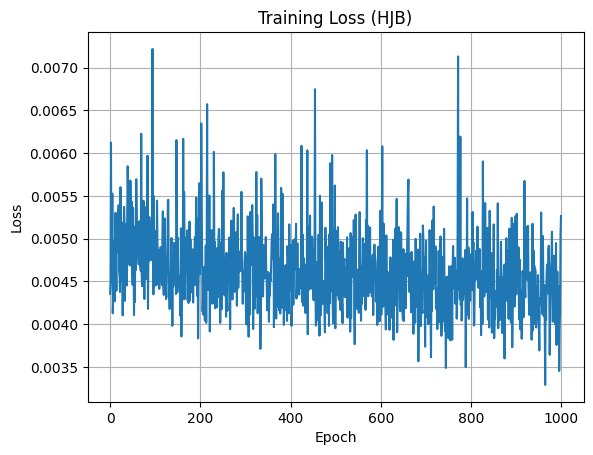

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
T = 1.0
N = 50
dt = T / N
sqrt_dt = np.sqrt(dt)
batch_size = 512
hidden_dim = 64

# Neural networks for Z (gradient of Y) and q (control)
class ControlNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

class GradientNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, t, x):
        inp = torch.cat([t, x], dim=1)
        return self.net(inp)

# Main BSDE model
class DeepHJB(nn.Module):
    def __init__(self):
        super().__init__()
        self.Y0 = nn.Parameter(torch.tensor([[1.0]], dtype=torch.float32))
        self.q_net = ControlNet().to(device)
        self.z_net = GradientNet().to(device)

    def forward(self):
        x = torch.zeros(batch_size, 1, device=device)
        t = torch.zeros(batch_size, 1, device=device)
        Y = self.Y0.repeat(batch_size, 1)

        loss = 0.0
        for _ in range(N):
            q = self.q_net(t, x)
            z = self.z_net(t, x)
            dW = torch.randn(batch_size, 1, device=device) * sqrt_dt
            cost = 0.5 * q**2

            x = x + q * dt + dW
            Y = Y - cost * dt + z * dW

            # Residual term
            Y_next = Y.clone().detach()
            # residual = Y_next - Y + cost * dt - z * dW
            # loss += torch.mean(residual**2)

            t += dt

        terminal_cost = 0.5 * x**2
        loss += torch.mean((Y - terminal_cost)**2)
        return loss, self.Y0

# Training loop
model = DeepHJB().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

# Load checkpoint if exists
if os.path.exists("checkpoint_hjb.pth"):
    checkpoint = torch.load("checkpoint_hjb.pth", map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print("Loaded existing checkpoint.")
else:
    print("No checkpoint found, training from scratch.")

best_loss = float('inf')
losses = []

for epoch in range(1000):
    optimizer.zero_grad()
    loss, y0 = model()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f} | y0 = {y0.item():.6f}")

        if loss.item() < best_loss:
            best_loss = loss.item()
            print("Saving checkpoint...")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, "checkpoint_hjb.pth")

# Plot the loss curve
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss (HJB)")
plt.grid(True)
plt.show()


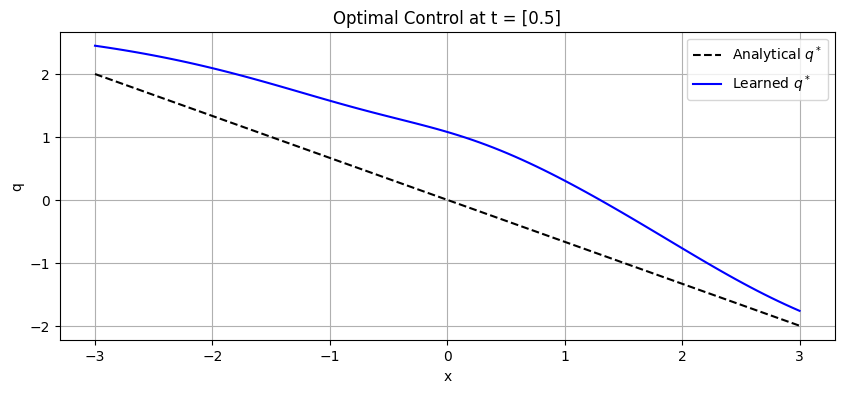

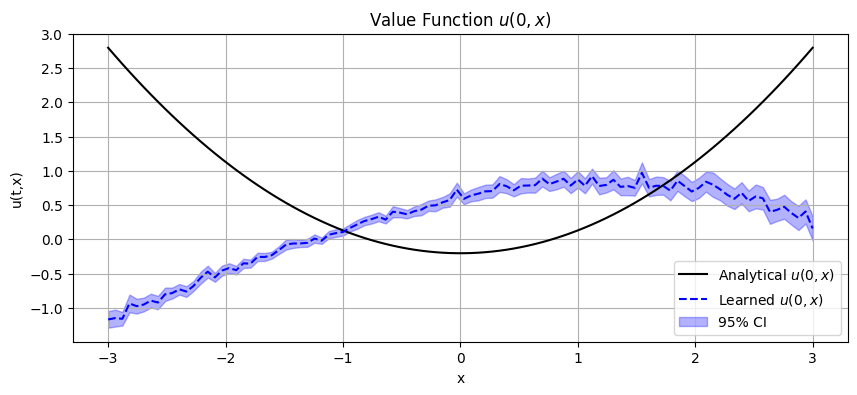

In [101]:
# === Define analytical solutions ===
def analytical_u(t, x, T=1.0, sigma=1.0):
    return 0.5 * x**2 / (1 + T - t) - 0.5 * sigma**2 * np.log(1 + T - t)

def analytical_q(t, x, T=1.0):
    return -x / (1 + T - t)

# Prepare test input grid
x_vals = np.linspace(-3, 3, 100).reshape(-1, 1)
t_fixed = 0.5 * np.ones_like(x_vals)

# Convert to torch tensors and move to the right device
x_tensor = torch.tensor(x_vals, dtype=torch.float32).to(device)
t_tensor = torch.tensor(t_fixed, dtype=torch.float32).to(device)

# Evaluate model's learned control
model.eval()
with torch.no_grad():
    q_learned = model.q_net(t_tensor, x_tensor).cpu().numpy().squeeze()

# Analytical values
q_true = analytical_q(t_fixed, x_vals).squeeze()
u_true = analytical_u(t_fixed, x_vals).squeeze()

# Plot optimal control
plt.figure(figsize=(10, 4))
plt.plot(x_vals, q_true, label="Analytical $q^*$", color='black', linestyle='--')
plt.plot(x_vals, q_learned, label="Learned $q^*$", color='blue')
plt.title(f"Optimal Control at t = {t_fixed[0]}")
plt.xlabel("x")
plt.ylabel("q")
plt.grid(True)
plt.legend()


def estimate_value_function(model, x_vals, t_val, T=1.0, steps=40, num_paths=200):
    dt = (T - t_val) / steps
    device = next(model.parameters()).device

    x_vals = np.array(x_vals).reshape(-1)
    n_x = len(x_vals)

    # Tensors: expand x_vals into multiple paths
    x_init = torch.tensor(x_vals, dtype=torch.float32, device=device).repeat(num_paths, 1)  # [num_paths, len(x_vals)]
    x_init = x_init.T.reshape(-1, 1)  # [n_x * num_paths, 1]
    t = torch.full_like(x_init, t_val)

    Y = model.Y0.expand(x_init.shape[0], 1).clone()
    x = x_init.clone()

    for _ in range(steps):
        z = model.z_net(t, x)
        q = model.q_net(t, x)
        dW = torch.randn_like(x) * np.sqrt(dt)
        x = x + q * dt + dW
        f = 0.5 * q**2
        Y = Y - f * dt + z * dW
        t = t + dt

    Y = Y.view(n_x, num_paths)  # [n_x, num_paths]
    Y_mean = Y.mean(dim=1).detach().cpu().numpy()
    Y_std = Y.std(dim=1).detach().cpu().numpy()
    ci_upper = Y_mean + 1.96 * Y_std / np.sqrt(num_paths)
    ci_lower = Y_mean - 1.96 * Y_std / np.sqrt(num_paths)

    return x_vals, Y_mean, ci_lower, ci_upper

x_vals, u_mean, ci_lower, ci_upper = estimate_value_function(model, x_vals, t_val=0.0)

plt.figure(figsize=(10, 4))
plt.plot(x_vals, u_true, label="Analytical $u(0,x)$", color='black')
plt.plot(x_vals, u_mean, label="Learned $u(0,x)$", color='blue', linestyle='--')
plt.fill_between(x_vals, ci_lower, ci_upper, color='blue', alpha=0.3, label="95% CI")
plt.title("Value Function $u(0,x)$")
plt.xlabel("x")
plt.ylabel("u(t,x)")
plt.legend()
plt.grid(True)
plt.show()
